#Лабораторная работа №2
####Емельянов Виталий, 293 группа

##1. Вспомогательные функции и загрузка датасета

In [225]:
import pandas
import numpy
import sklearn
import urllib2
from copy import deepcopy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
avg_precision = {}


def init_data():
    
    SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
    SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

    feature_names = [
        line.strip().split(':')[0] 
        for line in urllib2.urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
    ]
    spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))

    X, y = spam_data.ix[:, :-1].values, spam_data.ix[:, -1].values
    
    return (spam_data, X, y)

def recall_score(y_test, y_predicted):
    [[TN, FN], [FP, TP]] = sklearn.metrics.confusion_matrix(y_test, y_predicted)
    recall = float(TP) / (TP + FN + 0.0000001)    
    return recall
    
def print_statistics(y_test, y_predicted):
    
    [[TN, FN], [FP, TP]] = sklearn.metrics.confusion_matrix(y_test, y_predicted)
    accuracy = float(TP + TN) / (TP + TN + FP + FN + 0.0000001) * 100
    precision = float(TP) / (TP + FP + 0.0000001) * 100
    recall = float(TP) / (TP + FN + 0.0000001) * 100
    f1 = 2*float(TP) / (2*TP + FP + FN + 0.0000001) * 100 
    
    print ''.join(["Accuracy = ", str(accuracy), "%"])
    print ''.join(["Precision = ", str(precision), "%"])
    print ''.join(["Recall = ", str(recall), "%"])
    print ''.join(["F1 = ", str(f1), "%"])
    
    
def normalize_data(data):
    
    normalized_data = deepcopy(data)
    
    for column in data.columns:
        normalized_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
        
    normalized_X, normalized_y = normalized_data.ix[:, :-1].values, normalized_data.ix[:, -1].values
    
    return (normalized_data, normalized_X, normalized_y)


spam_data, X, y = init_data()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Количество писем в датасете

In [226]:
len(spam_data)

4601

Ответ: 4601 письмо

###Количество  и доля плохих писем

In [227]:
spam_data['spam'].sum()

1813

In [228]:
spam_data['spam'].mean() * 100

39.404477287546186

1813 "плохих" писем, что есть 39% от общего числа

###Характерные признаки в наборе

In [229]:
for column in spam_data.columns:
    print column, ' ',

word_freq_make   word_freq_address   word_freq_all   word_freq_3d   word_freq_our   word_freq_over   word_freq_remove   word_freq_internet   word_freq_order   word_freq_mail   word_freq_receive   word_freq_will   word_freq_people   word_freq_report   word_freq_addresses   word_freq_free   word_freq_business   word_freq_email   word_freq_you   word_freq_credit   word_freq_your   word_freq_font   word_freq_000   word_freq_money   word_freq_hp   word_freq_hpl   word_freq_george   word_freq_650   word_freq_lab   word_freq_labs   word_freq_telnet   word_freq_857   word_freq_data   word_freq_415   word_freq_85   word_freq_technology   word_freq_1999   word_freq_parts   word_freq_pm   word_freq_direct   word_freq_cs   word_freq_meeting   word_freq_original   word_freq_project   word_freq_re   word_freq_edu   word_freq_table   word_freq_conference   char_freq_;   char_freq_(   char_freq_[   char_freq_!   char_freq_$   char_freq_#   capital_run_length_average   capital_run_length_longest   capi

Характерными признаками являются частоты слов, которые зачастую  встречаются в спаме. Это слова: money, receive, all, credit и т.п.<br>
Также характерными признаками являются:
* частоты символов $, #, ! ...<br>
* отношения прописных и строчных букв


## 2. Обучение классификатора и оценка его качества

###Решающее дерево

Разобьем датасет на обучающую и тестовую выборки таким образом, что первые 3000 экземпляров будут лежать в обучающей выборке, а остальные - в тестовой.

In [230]:
train = spam_data.ix[:3000, :]
test = spam_data.ix[3000:, :]

Обучаем решающее дерево на train выборке и используем test выборку для оценки качества классификации

In [231]:
from sklearn.tree import DecisionTreeClassifier


X_train = train.ix[:, :train.shape[1]-1]
y_train = train['spam']

cls = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=0).fit(X_train, y_train)

X_test = test.ix[:, :test.shape[1]-1]
y_test = test['spam']

y_predicted = cls.predict(X_test)

print_statistics(y_test, y_predicted)

Accuracy = 77.1392879402%
Precision = 0.0%
Recall = 0.0%
F1 = 0.0%


Определим, почему мы получили такое качество классификации. Для этого "посмотрим" на train и test выборки

In [232]:
print y_train.mean()
print y_test.mean()

0.604131956015
0.0


Видно, что в test выборке находятся письма не являющиеся спамом, значит TP=0, и, так как в формуле для подсчета precision, recall и f1 в числителе стоит именно TP, этим и объясняется полученное качество классификации.<br><br>
Из этого примера сразу виден недостаток такой оценки качества: в тестовую выборки попали "однородные" объекты, что не дает нам адекватно оценить качество классификации. Следовательно, чтобы избежать таких ситуаций, мы должны рабивать на train и test выборки случайным образом.<br><br>
Повторим обучение решающего дерева, случайно перемешав объекты исходной выборки перед разбиением, которое мы произведем в том же соотношении

In [233]:
from sklearn.cross_validation import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000)

cls = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=0).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'dtree'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy = 91.0056214809%
Precision = 86.6359446872%
Recall = 90.821256024%
F1 = 88.679245276%


Видим, что качество классификации заметно возросло

####Наиболее важные признаки

Важность узла определяется его высотой в дереве. Чем выше узел, тем он важнее.

In [234]:
importances = cls.feature_importances_

for i in range(len(importances)):
    if importances[i]> 0.05:
        print spam_data.columns[i], importances[i]

word_freq_remove 0.136374512053
word_freq_free 0.0706819689883
char_freq_! 0.402382886759
capital_run_length_average 0.138410057946


Оказывается, что наиболее важными признаками оказались частоты слов "remove", "hp", а также частоты символов '!' и '$'.

###Константная модель

Обучим константную модель. Для каждого экземпляра выборки будем просто-напросто отвечать, что он принадлежит классу "не спам"

In [235]:
from sklearn.dummy import DummyClassifier 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000)

cls = DummyClassifier(strategy="constant", constant=0).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
print_statistics(y_test, y_predicted)



Accuracy = 61.3366645808%
Precision = 0.0%
Recall = 0.0%
F1 = 0.0%


Лучшая константная модель дает количество true negatives около 60% процентов.<br>
Это очевидно, ведь если мы все время будем отвечать 0, то ошибемся лишь в ~40% случаев, ведь у нас всего ~40% писем, помеченных как спам. Отсюда, соответственно, следует, что FN=40%, TN=TP=0% и оценки качества приведенные выше получатся подстановкой этих значений в формулы для метрик.

###KNN

Обучим модель K-ближайших соседей с K=10 и евклидовой метрикой

In [236]:
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000)

cls = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'knn'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy = 76.8269831307%
Precision = 63.4460547402%
Recall = 73.2342007299%
F1 = 67.9896462409%


###Масштабирование данных

Произведем масштабирование данных, то есть для каждого признака, отнормируем принимаемые им значения к значениям, лежащим на [0, 1].<br>
Посмотрим, как повлияет масштабирование на качество классификации.

####KNN

In [237]:
normalized_data, normalized_X, normalized_y = normalize_data(spam_data)
   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)
cls = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2).fit(X_train, y_train)

y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'normalized_knn'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)



Accuracy = 89.0693316621%
Precision = 78.6604361248%
Recall = 93.0018416035%
F1 = 85.2320675034%


Видим, что масштабирование заметно повлияло на качество классификации алгоритма KNN.<br>
Это связано с тем, что ранее признаки, имевшие большие значения (больший разброс значений) давали больший вклад в расстояние, что портило алгоритм классификации.<br> Теперь же все значения признаков лежат в [0, 1], и этот эффект устраняется.

####Решающее дерево

In [238]:
normalized_data, normalized_X, normalized_y = normalize_data(spam_data)   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)

cls = DecisionTreeClassifier(criterion='gini', max_depth=7).fit(X_train, y_train)
y_predicted = cls.predict(X_test)
y_probs = cls.predict_proba(X_test)

classifier_name = 'normalized_dtree'
fpr[classifier_name], tpr[classifier_name], thresholds = roc_curve(y_test, y_probs[:, 1])
roc_auc[classifier_name] = auc(fpr[classifier_name], tpr[classifier_name])
precision[classifier_name], recall[classifier_name], _ = precision_recall_curve(y_test, y_probs[:, 1])
avg_precision[classifier_name] = average_precision_score(y_test, y_probs[:, 1])

print_statistics(y_test, y_predicted)

Accuracy = 91.3179262904%
Precision = 86.3636363501%
Recall = 91.3764510628%
F1 = 88.7993553514%


Масштабирование не повлияло на качество классификации алгоритма решаюшего дерева, что естественно, так как в каждой  вершине дерева рассматривается только один признак.<br> 
Ведь если мы умножаем два числа на одно и то же ненулевое положительное число, то это не влияет на то как эти два числа между собой соотносятся.

На данном этапе мы видим, что лучшее качество классификации при данной оценке качества дает решающее дерево.<br>
За ней идет модель KNN с нормированными признаками.<br>
Далее - модель KNN с ненормированными признаками. И, естественно, в конце - константная модель.

##3. Выбор порога классификации


Классификатор имеет AUC-ROC близкий к нулю, если он часто совершает ошибку первого рода (false positive).<br>
То есть в тех случаях, когда нужно отнести объект к отрицательному классу, он относит его к положительному.<br>
Иными словами, это идеальный классификатор для инвертированных признаков.

Я считаю, что алгоритм K-ближайших соседей действует путем сравнения оценки принадлежности к определенному классу с порогом. Потому что в пограничном состоянии когда, например, соседей одного класса больше на 1, чем соседей другого класса, важную роль будет играть именно порог. С другой стороны, для решающего дерева никаких порогов, кажется, не должно быть.<br>
Явного ответа на этот вопрос в документации я не нашел.

###ROC-кривая

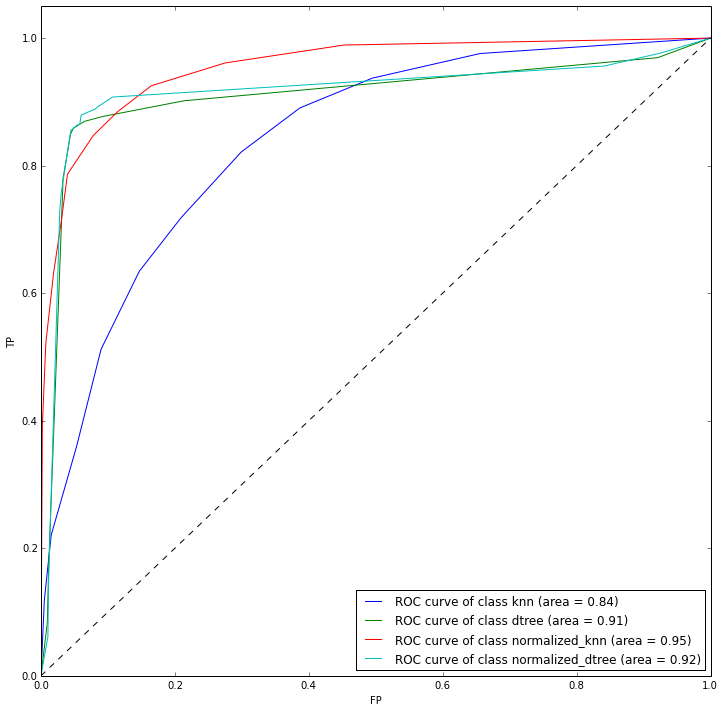

In [239]:
plt.figure(figsize = (12, 12))

for key in fpr.keys():
    plt.plot(fpr[key], tpr[key], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(key, roc_auc[key]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.legend(loc="lower right")
plt.show()

###Precision/Recall кривая

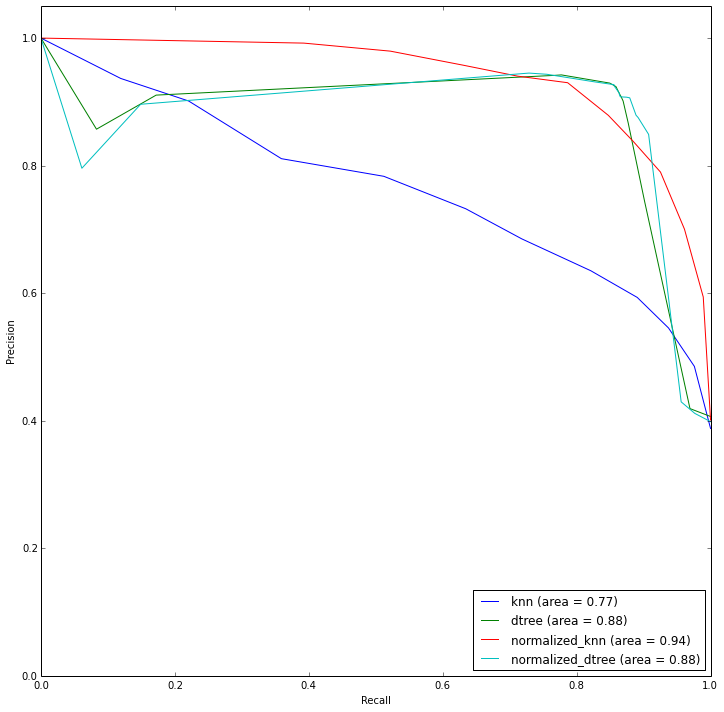

In [240]:
plt.figure(figsize = (12, 12))

for key in precision.keys():    
    plt.plot(recall[key], precision[key],
    label='{0} (area = {1:0.2f})'
    ''.format(key, avg_precision[key]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.show()

Определим, какой максимальной полноты определения спама достигают классификаторы, если их точность должна быть выше 90%

In [241]:
for key in recall.keys():
    max_recall = 0
    for i in xrange(len(precision[key])):
        if precision[key][i] > 0.9:
            max_recall = max(max_recall, recall[key][i])
    print key, 'max recall =', max_recall

knn max recall = 0.220611916264
dtree max recall = 0.869431643625
normalized_knn max recall = 0.786604361371
normalized_dtree max recall = 0.879310344828


##4. Кросс-валидация и подбор параметров

Будем оптимизировать по метрике recall - долей спама, которая была отфильтрована.

In [242]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import cross_val_score as CVS
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


normalized_data, normalized_X, normalized_y = normalize_data(spam_data)   
X_train, X_test, y_train, y_test = train_test_split(normalized_X, normalized_y, train_size=3000)

###Оптимальный набор параметров дерева

In [243]:
params = {'max_depth': range(2,20),
          'criterion': ['entropy', 'gini']}
grid_searcher = GridSearchCV(DecisionTreeClassifier(), \
                             params, cv = KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=17), \
                             scoring=make_scorer(recall_score), n_jobs=3) 
cls = grid_searcher.fit(X_train, y_train)
y_predict = cls.predict(X_test)

print grid_searcher.best_estimator_

print_statistics(y_predict, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
Accuracy = 89.4440974335%
Precision = 93.5613681904%
Recall = 77.2425249041%
F1 = 84.6223839777%


###Оптимальный набор параметров KNN

In [244]:
params = {'n_neighbors': range(3, 10),
          'weights': ['distance', 'uniform']}

grid_searcher = GridSearchCV(KNN(), \
                             params, cv = KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=123), \
                             scoring=make_scorer(recall_score), n_jobs=3) 


cls = grid_searcher.fit(X_train, y_train)
y_predict = cls.predict(X_test)

print grid_searcher.best_estimator_

print_statistics(y_predict, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=4, p=2, weights='uniform')
Accuracy = 88.0074953099%
Precision = 89.7286821532%
Recall = 76.9102989905%
F1 = 82.8264758423%


Сравнивая с предыдущими результатами метрики качества, делаем вывод, что мы нашли более оптимальные параметры в пределах сетки.